In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import sys
import pickle

# Description
### This script is an excercise of **Metalabelling** (introduced by *Marcos M. Lopez de Prado*).

It utilizes the **Triple-barrier Labelling** to identify price trends and use **price features** to train a **trend prediction model** with **Random Forest** classifier. <br>

The prediction model is a successful strategy in terms of satisfying **Sharpe Ratio** and positive **Information Ratio**, except in `SPY`. <br>
On `GLD`, it is obtaining a healthy **SR of 0.83** and a **positive skew of 0.20**.

*Author - Ben* <br>
*Last update - 15/3/2024*

# Data
Investment universe: <br>
`SPY` - Equity proxy <br>
`TLT` - Bond proxy <br>
`SVXY` - (short) Volatility proxy <br>
`GLD` - Gold proxy <br>

In [24]:
symbols = ["SPY", "TLT", "SVXY", "GLD"]
all_data = dict()
for symbol in symbols:
    # only close price is used for simplicity
    prc = yf.download(symbol).Close
    # convert to log price
    logprc = np.log(prc)
    all_data[symbol] = logprc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Features
### 8 features with 60 days (~1 months) lookback

##### They can be categorize in four types:
**Technical Indicator**

>1. EMA Crossover normalized by Volatility - measure trend strength: <br>
$EMAC=\frac{EMA(P,lookback)-EMA(P,lookback\times4)}{VOL(P,lookback)}$

>2. RSI - predict reversal: <br>
$RSI=RSI(P,lookback)$

**Trend Strength** - parameters obtained from OLS of price against time 

>3. Slope of OLS normalized by Volatility - measure trend strength: <br>
$SLOPE=\frac{\beta_1}{VOL(P,lookback)}$

>4. R-squared of OLS - measure the volatility around the strend: <br>
$R2$

>5. Slope * R-squared - combined score of trend stregth:<br>
$SLR2=SLOPE\times R2$

**Return Distribution**

>6. Volatility (Stdev): <br>
$VOL=Std(Ret)$

>7. Skewness - heavy skew indicate a big move has occurred, hence it may predict a reversal: <br>
$SKEW=Skew(Ret)$

>8. Kurtosis - heavy tail indicate a big move has occurred, hence it may predict a reversal: <br>
$KURT=Kurt(Ret)$

In [25]:
from scipy.stats import linregress
from ta.momentum import rsi
from numpy.lib.stride_tricks import sliding_window_view


def get_feat(logprc, lookback):
    TA = get_TA(logprc, lookback)
    TREND = get_TREND(logprc, lookback)
    DIST = get_DIST(logprc, lookback)
    feat = pd.concat([TA, TREND, DIST], axis=1).dropna()
    return feat


def get_TA(logprc, lookback):
    vol = logprc.diff().rolling(lookback).std()
    EMAC = (logprc.ewm(lookback).mean() - logprc.ewm(lookback * 4).mean()) / vol
    RSI = rsi(logprc, lookback)
    TA = pd.DataFrame({"EMAC": EMAC, "RSI": RSI})
    return TA


def get_TREND(logprc, lookback):
    def ols_time(logprc):
        y, x = logprc, np.arange(logprc.shape[0])
        reg = linregress(x, y)
        slope, r2 = reg[0], reg[2] ** 2
        slr2 = slope * r2
        return slope, r2, slr2

    # vectorize approach to run rolling OLS

    # create rolling datasets for each day
    rolling = sliding_window_view(logprc, window_shape=lookback)
    # apply OLS function on each dataset
    TREND = np.apply_along_axis(ols_time, axis=1, arr=rolling)
    TREND = pd.DataFrame(
        TREND, columns=["SLOPE", "R2", "SLR2"], index=logprc.index[lookback - 1 :]
    )
    vol = logprc.diff().rolling(lookback).std()
    TREND["SLOPE"] = TREND["SLOPE"] / vol

    return TREND


def get_DIST(logprc, lookback):
    VOL = logprc.diff().rolling(lookback).std()
    SKEW = logprc.diff().rolling(lookback).mean()
    KURT = logprc.diff().rolling(lookback).kurt()
    DIST = pd.DataFrame({"VOL": VOL, "SKEW": SKEW, "KURT": KURT})
    return DIST

In [26]:
all_feat = dict()
lookback = 60
for symbol in symbols:
    data = all_data[symbol]
    feat = get_feat(data, lookback)
    all_feat[symbol] = feat

### Briefly check the correlation (Spearman) between features
The plot is sorted by average correlation <br>
`RSI` , `SLOPE` , `SLR2` , `SKEW` shows high correlation in all four assets

SPY avg corr:
{'VOL': -0.2, 'KURT': 0.17, 'EMAC': 0.29, 'R2': 0.37, 'RSI': 0.48, 'SKEW': 0.51, 'SLOPE': 0.53, 'SLR2': 0.53}
TLT avg corr:
{'VOL': 0.08, 'R2': 0.13, 'KURT': 0.18, 'EMAC': 0.22, 'RSI': 0.46, 'SLOPE': 0.47, 'SKEW': 0.47, 'SLR2': 0.47}
SVXY avg corr:
{'VOL': -0.06, 'KURT': 0.03, 'EMAC': 0.3, 'R2': 0.35, 'RSI': 0.48, 'SLOPE': 0.49, 'SKEW': 0.5, 'SLR2': 0.51}
GLD avg corr:
{'KURT': 0.1, 'VOL': 0.22, 'R2': 0.25, 'EMAC': 0.33, 'RSI': 0.51, 'SKEW': 0.52, 'SLOPE': 0.52, 'SLR2': 0.53}


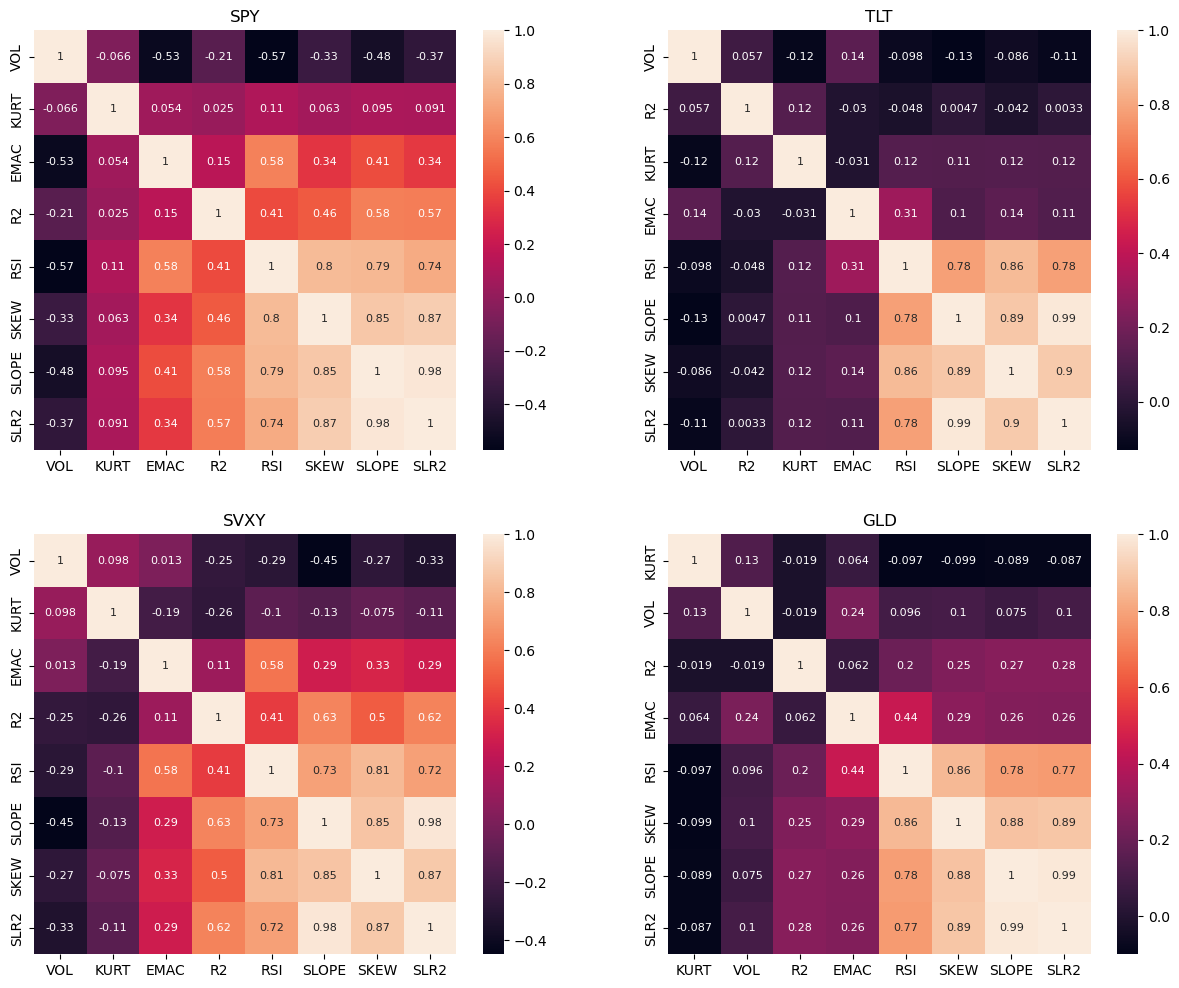

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, symbol in enumerate(symbols):
    ax = axes[i // 2, i % 2]
    ax.set_title(symbol)

    feat = all_feat[symbol]
    # corr = feat.corr(method='pearson')
    corr = feat.corr(method="spearman")
    avg_corr = corr.mean().sort_values(ascending=True)
    print(f"{symbol} avg corr:")
    print(np.around(avg_corr, 2).to_dict())

    sns.heatmap(
        corr.loc[avg_corr.index, avg_corr.index],
        annot=True,
        annot_kws={"size": 8},
        ax=ax,
    )

# Triple-barrier Label
### Use upper, lower, and time bounds to determine whether a trend is established

1. Upper bound is defined as a positive number times volatility*. When the cumulative return touched upper bound, it is considered an uptrend.

2. Lower bound is defined as a negative number times volatility. When the cumulative return touched lower bound, it is considered a downtrend.

3. Time bound is defined as a fixed holding horizon. When the holding days touched time bound, it is considered no trend within the period

*`lookback = 60` (arbitrary) for a stabler measure

$Label = \left\{
  \begin{array}{ c l }
    +1 & \quad \textrm{if cumulative return >= upper bound} \\
    -1 & \quad \textrm{if cumulative return <= lower bound} \\
    0 & \quad \textrm{if holding days >= time bound and none of vertical bounds are touched}
  \end{array}
\right.$


### Rolling approach

In [28]:
def get_label(logprc, window):
    logret = logprc.diff().shift(-1)
    vol = logret.rolling(60).std()

    tp = window**0.5
    sl = window**0.5
    hd = window

    # print(tp , sl , hd)
    label = []

    for i, ret in logret.items():
        up_bar = vol.loc[i] * tp
        low_bar = vol.loc[i] * -sl
        time_bar = hd

        future_ret = logret.loc[i:]
        cum_ret = ret
        cum_day = 1
        while True:
            if cum_ret >= up_bar:
                label.append(1)
                break
            elif cum_ret <= low_bar:
                label.append(-1)
                break
            elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
                label.append(0)
                break

            ret = future_ret.iloc[cum_day]
            cum_day += 1
            cum_ret += ret

    label = pd.Series(label, index=logret.index, name="LABEL")
    return label

### Vectorized approach (not implemented)

In [29]:
def get_label(logprc, window):
    logret = logprc.diff().shift(-1)
    vol = logprc.diff().rolling(60).std()

    tp = window**0.5
    sl = window**0.5
    hd = window

    time_bar = hd
    up_bar = (tp * vol).iloc[
        :-time_bar
    ]  # drop last n days as the labelling is forward looking
    low_bar = (-sl * vol).iloc[
        :-time_bar
    ]  # drop last n days as the labelling is forward looking

    # vectorize approach to run rolling Labelling
    # create rolling datasets for each day
    rolling = sliding_window_view(logret, window_shape=time_bar)
    cumret = rolling.cumsum(axis=1)[:-1]
    max_cumret = cumret.max(axis=1)
    min_cumret = cumret.min(axis=1)

    is_up = np.where(max_cumret >= up_bar, 1, 0)
    is_low = np.where(min_cumret <= low_bar, -1, 0)
    label = pd.Series(is_up + is_low, index=up_bar.index, name="LABEL")
    return label

###

In [30]:
all_label = dict()
for symbol in symbols:
    data = all_data[symbol]
    label = get_label(data, window=lookback)
    all_label[symbol] = label

### Visualize the labelling method (sanity check)
<font color='green'>Green</font> zone means there is an uptrend identified. <br>
<font color='red'>Red</font> zone means there is an downtrend identified. <br>
<font color='gray'>Gray</font> zone means there is no obvious trend. <br>

Green = Uptrend
Red   = Downtrend
Gray  = No trend
(Here shows the label every 60 days for visibility, but it is updated everyday)


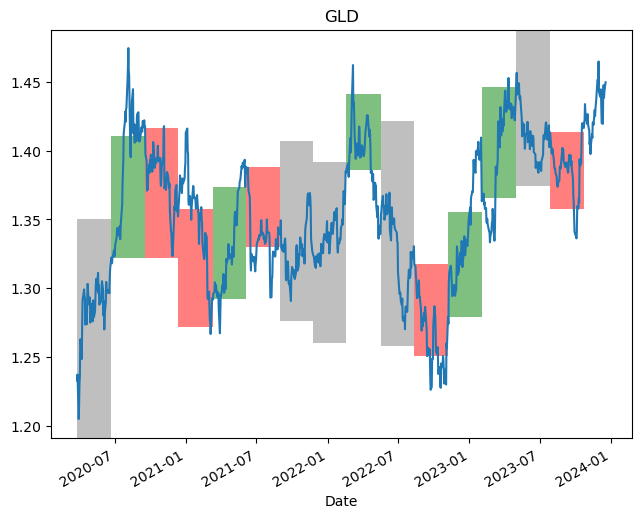

In [31]:
from matplotlib.patches import Rectangle

cum_ret = data.diff().shift(-1).cumsum()
vol = data.diff().rolling(60).std()

up_bar = lookback**0.5 * vol
low_bar = lookback**0.5 * vol
time_bar = lookback

period = cum_ret.index[-1000:-time_bar]
dates = cum_ret.loc[period].index

sub_label = label.loc[period][::time_bar]
sub_cum_ret = cum_ret.loc[period]

ax = sub_cum_ret.plot(title=symbol, figsize=(7.5, 6))

print("Green = Uptrend")
print("Red   = Downtrend")
print("Gray  = No trend")
print(
    f"(Here shows the label every {time_bar} days for visibility, but it is updated everyday)"
)

for i, lab in enumerate(sub_label):
    if i + 1 >= len(sub_label):
        break

    if lab == 1:
        w = sub_label.index[i + 1] - sub_label.index[i]
        h = up_bar.loc[sub_label.index[i]]
        x = sub_label.index[i]
        y = sub_cum_ret[sub_label.index[i]]

        rect = Rectangle((x, y), w, h, facecolor="g", alpha=0.5)
        ax.add_patch(rect)
    elif lab == -1:
        w = sub_label.index[i + 1] - sub_label.index[i]
        h = up_bar.loc[sub_label.index[i]]
        x = sub_label.index[i]
        y = sub_cum_ret[sub_label.index[i]] - h

        rect = Rectangle((x, y), w, h, facecolor="r", alpha=0.5)
        ax.add_patch(rect)
    elif lab == 0:
        w = sub_label.index[i + 1] - sub_label.index[i]
        h = up_bar.loc[sub_label.index[i]] * 2
        x = sub_label.index[i]
        y = sub_cum_ret[sub_label.index[i]] - h / 2

        rect = Rectangle((x, y), w, h, facecolor="gray", alpha=0.5)
        ax.add_patch(rect)

# Concat features and label into one dataframe

In [32]:
all_dataset = dict()
for symbol in symbols:
    label = all_label[symbol]
    feat = all_feat[symbol]
    dataset = pd.concat([label, feat], axis=1).dropna()
    all_dataset[symbol] = dataset

# Random Forest Prediction
### Here run a walk-forward testing to evaluate the predictability

**Model setting (arbitrary)**
- `random_state = 300300`
- `n_estimators = 1000`
- `max_depth = 3`

**Training setting (arbritrary)**
- `step = lookback` - the model is retrained every n days
- `train_size = 1250 - lookback` - last 5 years minus the last n days used for labelling to avoid looking ahead

In [33]:
from sklearn.ensemble import RandomForestClassifier

train_size = 1250
step = lookback

all_rf_pred = dict()
all_rf_prob = dict()

for symbol in symbols:
    print(symbol)
    rf_pred_list = []
    rf_prob_list = []

    dataset = all_dataset[symbol]
    for start in range(train_size, len(dataset), step):
        # rolling train set
        train_set = dataset.iloc[start - train_size : start - lookback]
        # expanding train set
        # train_set = dataset.iloc[ : start - lookback]
        test_set = dataset.iloc[start : start + step]

        train_y, train_x = train_set["LABEL"], train_set.drop(columns="LABEL")
        test_x = test_set.drop(columns="LABEL")

        rf = RandomForestClassifier(random_state=300300, n_estimators=1000, max_depth=3)
        rf.fit(X=train_x, y=train_y)

        # append the output from model to a list, concat them later
        rf_pred_list.append(
            pd.Series(rf.predict(X=test_x), index=test_x.index, name="PRED")
        )
        rf_prob_list.append(
            pd.DataFrame(
                rf.predict_proba(X=test_x),
                index=test_x.index,
                columns=np.sort(train_y.unique()),
            )
        )

    rf_pred = pd.concat(rf_pred_list)
    rf_prob = pd.concat(rf_prob_list)
    all_rf_pred[symbol] = rf_pred
    all_rf_prob[symbol] = rf_prob

SPY
TLT
SVXY
GLD


# Evaluate performance

### Confusion Matrix
##### Here show the accuracy of each class of prediction
For example: <br>
$\%\ True\ Up=\frac{Number\ of\ True\ Up}{Number\ of\ Predicted\ Up}$ <br> <br>
$\%\ False\ Up=\frac{Number\ of\ True\ Down}{Number\ of\ Predicted\ Up}$

**Result**
1. Among all prediction of no trend, around a half is missed trend <br>

2. Prediction of downtrend is more accurate, 3 of 4 markets shows a higher relative accuracy* <br>

- *An inituitive guess: Value of volatility (`VOL`) is less ambigious during market turmoil*<br>

*$Relative\ Accuracy\ of\ Up=\frac{\%\ True\ Up}{\%\ False\ Up}$ <br>

In [34]:
from sklearn.metrics import confusion_matrix


def get_conf_mat(y_pred, y_true, k_list=None, pred_rate=False):
    if k_list is None:
        k_list = np.sort(y_true.unique())
    cm = pd.DataFrame(
        confusion_matrix(y_pred=y_pred, y_true=y_true),
        index=pd.Index(k_list, name="True"),
        columns=pd.Index(k_list, name="Pred"),
    )
    if pred_rate:
        cm = np.around(cm.div(cm.sum(axis=0), axis=1), 2)
    return cm

In [35]:
# fig,axes = plt.subplots(2,2,figsize=(15,12))
for i, symbol in enumerate(symbols):
    # ax = axes[i//2,i%2]
    # ax.set_title(symbol)

    pred_true = pd.DataFrame(
        {"Pred": all_rf_pred[symbol], "True": all_dataset[symbol].loc[:, "LABEL"]}
    ).dropna()
    cm = get_conf_mat(
        y_pred=pred_true["Pred"],
        y_true=pred_true["True"],
        k_list=["up", "none", "down"],
        pred_rate=True,
    )
    print(f"======== {symbol} ========")
    print(cm)
    print()
    # sns.heatmap(cm, annot=True, annot_kws={"size":8}, ax=ax)

======== SPY ========
Pred    up  none  down
True                  
up    0.25  0.23  0.22
none  0.46  0.53  0.48
down  0.29  0.24  0.30

======== TLT ========
Pred    up  none  down
True                  
up    0.22  0.23  0.22
none  0.57  0.51  0.38
down  0.20  0.26  0.40

======== SVXY ========
Pred    up  none  down
True                  
up    0.26  0.17  0.17
none  0.35  0.59  0.58
down  0.40  0.24  0.25

======== GLD ========
Pred    up  none  down
True                  
up    0.26  0.21  0.27
none  0.38  0.51  0.38
down  0.36  0.28  0.36



### Profitability

##### Backtester
Simulates a trading process

In [36]:
def init_trade(direction, vol, ret, tp, sl, hd):
    up_bar = vol * tp
    low_bar = vol * -sl
    time_bar = hd
    pnl_d = direction * ret
    cum_ret = direction * ret
    cum_day = 1
    return up_bar, low_bar, time_bar, pnl_d, cum_ret, cum_day


def cont_trade(direction, ret, cum_ret, cum_day):
    pnl_d = direction * ret
    cum_ret += direction * ret
    cum_day += 1
    return pnl_d, cum_ret, cum_day


def get_pnl(pred, prob, logret, tp, sl, hd, p_thr=None, trail_sl=False):
    vol = logret.rolling(60).std()

    if p_thr is None:
        p_thr = 1 / prob.shape[1]  # 1/n for n class

    # print(tp , sl , hd)
    pnl = []
    in_pos = False
    direction = None
    cooldown = 0

    for i, pred_i in pred.items():
        # additional filter:
        # if a trade is being closed, next trade will be opened after cool down
        if cooldown >= 0:
            cooldown -= 1
            pnl.append(0)
            continue
        if not in_pos and pred_i != 0 and prob.loc[i, pred_i] >= p_thr:
            # 1. Not taking trade;
            #    Predicted a trend;
            #    Prob > threshold;

            # -> Take a trade, initialize the trade
            direction = pred_i
            up_bar, low_bar, time_bar, pnl_d, cum_ret, cum_day = init_trade(
                direction, vol.loc[i], logret.loc[i], tp, sl, hd
            )
            pnl.append(pnl_d)

            # break if any of bar is touched
            if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= time_bar:
                in_pos = False
                cooldown = time_bar - cum_day

        elif in_pos and pred_i == direction and prob.loc[i, direction] >= p_thr:
            # 2. Taking a trade;
            #    The trend is predicted to continue;
            #    Prob > threshold;

            # -> Continue the trade, record the pnls
            pnl_d, cum_ret, cum_day = cont_trade(
                direction, logret.loc[i], cum_ret, cum_day
            )
            pnl.append(pnl_d)

            # shift up low_bar if trailing stop loss
            if trail_sl and pnl_d > 0:
                low_bar += pnl_d

            # break if any of bar is touched
            if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= time_bar:
                in_pos = False
                cooldown = time_bar - cum_day

        elif in_pos and pred_i != direction and prob.loc[i, pred_i] < p_thr:
            # 3. Taking a trade;
            #    Pred is inconsistent with current position;
            #    But prob of reverse trend < threshold;

            # -> Record the pnls, close all positions
            pnl_d, cum_ret, cum_day = cont_trade(
                direction, logret.loc[i], cum_ret, cum_day
            )
            pnl.append(pnl_d)
            in_pos = False

        elif in_pos and pred_i != direction and prob.loc[i, pred_i] >= p_thr:
            # 4. Taking a trade;
            #    Pred is inconsistent with current position;
            #    Prob of reverse trend >= threshold;

            # -> Take reverse trade, reinitialize the trade
            direction = pred_i
            up_bar, low_bar, time_bar, pnl_d, cum_ret, cum_day = init_trade(
                direction, vol.loc[i], logret.loc[i], tp, sl, hd
            )
            pnl.append(pnl_d)

            # break if any of bar is touched
            if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= time_bar:
                in_pos = False
                cooldown = time_bar - cum_day

        else:
            # 5. Not taking any trade
            pnl.append(np.nan)

    pnl = pd.Series(pnl, index=pred.index, name="PNL")
    return pnl

##### Cumalative Profit

**Results**

1. Number of taken trades is low <br>
(30-45% of time in position)

2. Generally profitable, but the sample size is small

3. Eyeballing: big losses usually occurs when asset price recover from drawdown <br>
(e.g. `SPY` during 2009 , `TLT` during 2020)

SPY: 2340 / 6468 days in position (36.18%)
TLT: 1301 / 4075 days in position (31.93%)
SVXY: 649 / 1762 days in position (36.83%)
GLD: 1606 / 3493 days in position (45.98%)


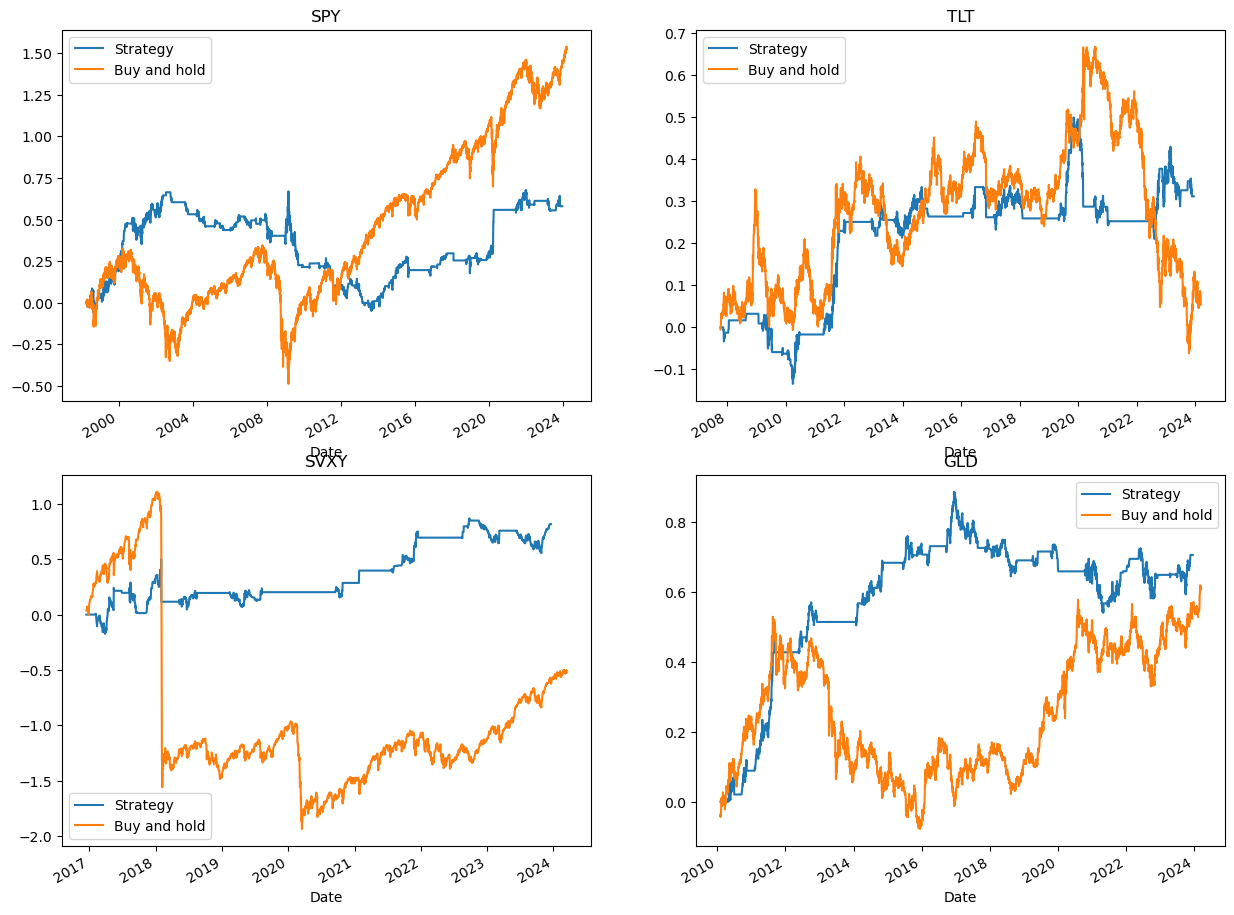

In [37]:
# take profit and stop loss can set tighter in trading relative to labelling
tp = lookback**0.5
sl = lookback**0.5
hd = lookback
p_thr = 0.33  # only open a position when the prob is > 1/3 (equivalent to class prob)

port_pnl = pd.DataFrame()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, symbol in enumerate(symbols):
    logret = all_data[symbol].diff().shift(-1)
    pred = all_rf_pred[symbol]
    prob = all_rf_prob[symbol]
    pnl = get_pnl(
        pred, prob, logret, tp, sl, hd, p_thr, trail_sl=True
    )  # trailing stop loss has been tested, effect is marginal
    # pnl = pred * logret
    port_pnl[symbol] = pnl

    in_pos_days = pnl[~pnl.isnull()].shape[0]
    total_days = pnl.shape[0]
    print(
        f"{symbol}: {in_pos_days} / {total_days} days in position ({in_pos_days/total_days:.2%})"
    )

    ax = axes[i // 2, i % 2]
    ax.set_title(symbol)
    start_day = pnl.dropna().index[0]
    pnl.fillna(0).loc[start_day:].cumsum().plot(ax=ax)
    logret.loc[start_day:].cumsum().plot(ax=ax)  # , secondary_y=True)
    ax.legend(["Strategy", "Buy and hold"])

##### Evaluator

In [49]:
from statsmodels.api import OLS, add_constant


def get_stats(pnl, logret=None):
    pnl = pnl.copy()
    # pnl.loc[pnl == 0] = np.nan
    mu = pnl.mean() * 252
    vol = pnl.std() * 252**0.5
    skew = pnl.skew()
    kurt = pnl.kurt()
    dd = (np.exp(pnl.cumsum()) / np.exp(pnl.cumsum()).cummax()) - 1
    avg_dd = dd[dd < 0].mean()
    max_dd = dd.min()
    sr = mu / vol
    pf = pnl[pnl > 0].sum() / -pnl[pnl < 0].sum()

    if logret is not None:
        temp = pd.concat([pnl, logret], axis=1).dropna()
        y, x = temp.iloc[:, 0], temp.iloc[:, 1]
        excret = (y - x).dropna()
        ir = excret.mean() / excret.std() * 252**0.5
        model = OLS(y, add_constant(x))
        result = model.fit()
        a, b, p = result.params[0] * 252, result.pvalues[1], result.pvalues[0]
    else:
        a, b, p, ir = None, None, None, None

    stats = pd.Series(
        {
            "Mean": mu,
            "Vol": vol,
            "Skew": skew,
            "Kurt": kurt,
            "Avg Drawdown": avg_dd,
            "Max Drawdown": max_dd,
            "Sharpe Ratio": sr,
            "Information Ratio": ir,
            "Profit Factor": pf,
            "Alpha": a,
            "P-value": p,
            "Beta": b,
        }
    )
    return stats

##### Performance Metrics
**Results**

Results are inflated due to low trade number

1. Except `SPY`, profitability is improved evidenced by significant Information Ratio and increased in Sharpe Ratio*<br>
**(0 risk-free rate for simplicity)*

2. Only `GLD` shows a possibly significant $\alpha$ (relative to the underlying)

3. $\beta$ is near zero, which means the strategy does not share market risk

4. Skewness does not show a pattern, but Kurtosis is quite high

In [70]:
perf = pd.DataFrame()
print("SR")
for symbol in symbols:
    logret = all_data[symbol].diff().shift(-1)
    print(f"{symbol} {logret.mean()/logret.std()*252**0.5:.2f}", end=" , ")
    perf[symbol] = get_stats(port_pnl[symbol], logret)

perf["Equal Weighted Portfolio"] = get_stats(port_pnl.mean(axis=1))
pd.set_option("display.float_format", lambda x: "%.3f" % x)
print("\nFollowing results are benchmarking on the underlying")
perf

SR
SPY 0.42 , TLT 0.04 , SVXY 0.18 , GLD 0.44 , 
Following results are benchmarking on the underlying


,SPY,TLT,SVXY,GLD,Equal Weighted Portfolio
Mean,0.062,0.060,0.317,0.111,0.090
Vol,0.188,0.148,0.465,0.135,0.173
Skew,0.263,-0.302,-2.280,0.206,-0.130
Kurt,4.866,1.741,53.800,2.647,12.601
Avg Drawdown,-0.219,-0.073,-0.172,-0.125,-0.108
Max Drawdown,-0.513,-0.251,-0.366,-0.293,-0.397
Sharpe Ratio,0.333,0.407,0.683,0.823,0.518
Information Ratio,-0.357,0.287,0.377,0.268,NaN
Profit Factor,1.062,1.070,1.164,1.155,1.101
Alpha,0.027,0.060,0.324,0.096,NaN
